In [115]:
# resources 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import scipy.stats as stats
import warnings

# collect data
from bcb import sgs

# modeling series 
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsforecast.arima import arima_string

# ploting
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler, Normalizer

# ignore warnings
warnings.filterwarnings('ignore')

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

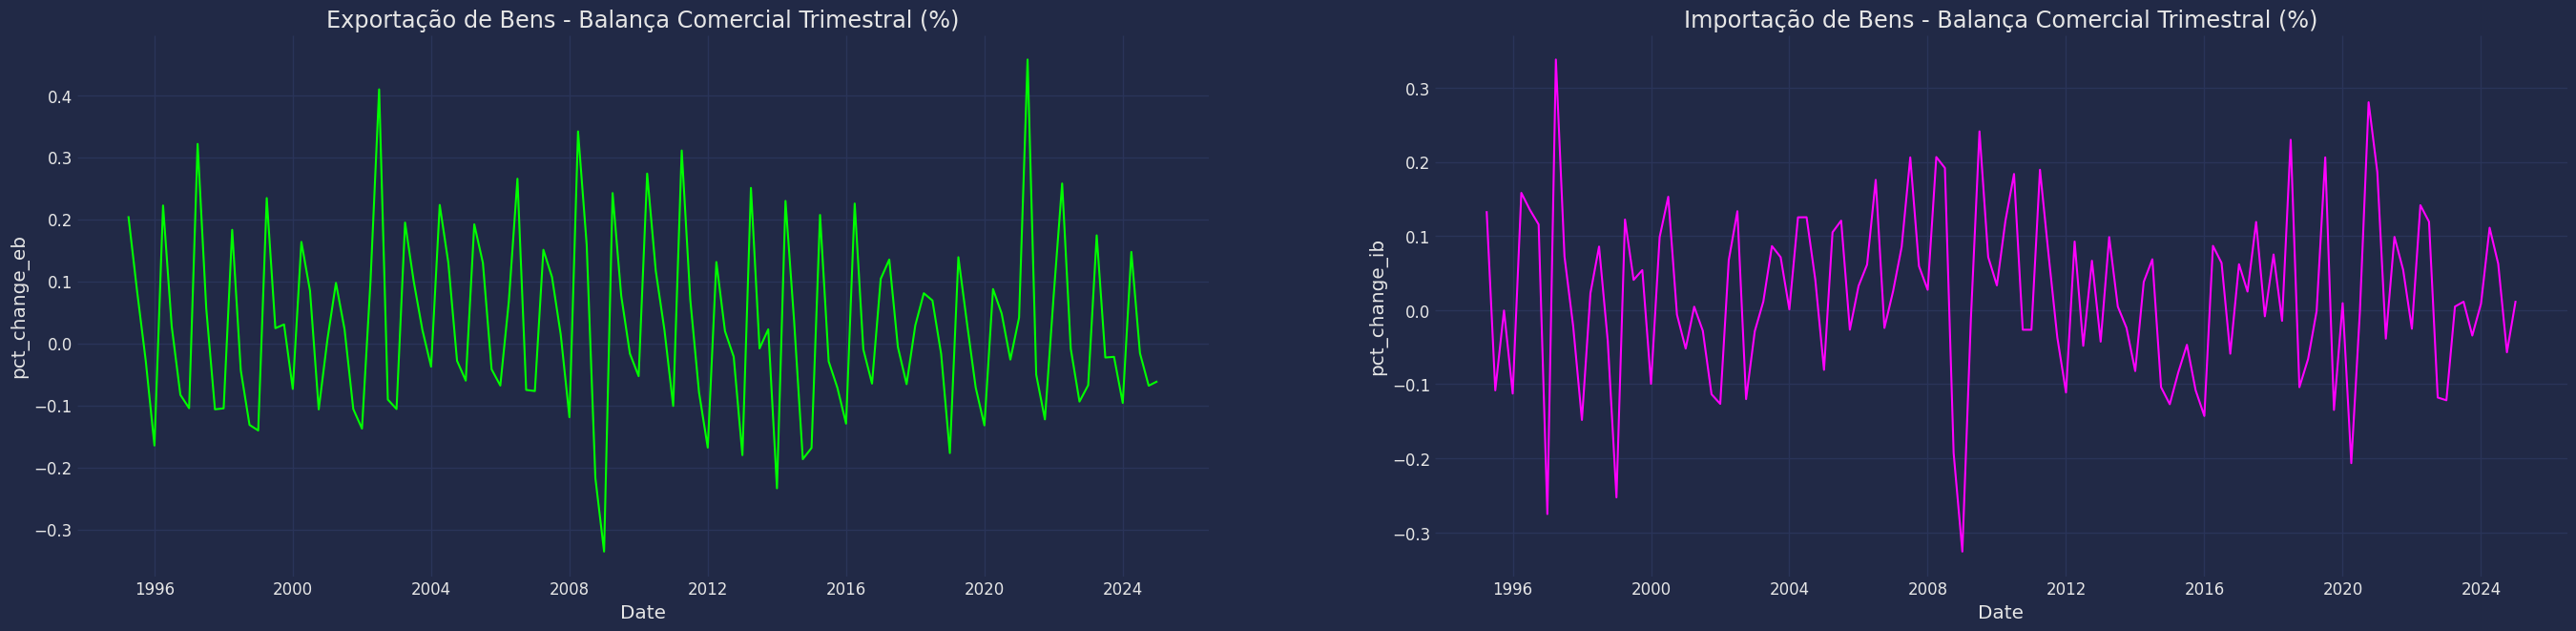

In [117]:
BALANCA_COMERCIAL_TRIMESTRAL = {
    'BALANCA_COMERCIAL': 23087,
    'EXPORTACAO_BENS': 23088,
    'IMPORTACAO_BENS': 23089
}

bc_tri = pd.DataFrame(sgs.get(BALANCA_COMERCIAL_TRIMESTRAL))
bc_tri['pct_change_bc'] = bc_tri['BALANCA_COMERCIAL'].pct_change()
bc_tri['pct_change_eb'] = bc_tri['EXPORTACAO_BENS'].pct_change()
bc_tri['pct_change_ib'] = bc_tri['IMPORTACAO_BENS'].pct_change()
bc_tri_not_float = bc_tri[['pct_change_eb', 'pct_change_ib']].round(2)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 7), sharex=True)

sns.lineplot(data=bc_tri, x=bc_tri.index, y='pct_change_eb', ax=axs[0], color='lime')
axs[0].set_title('Exportação de Bens - Balança Comercial Trimestral (%)')
sns.lineplot(data=bc_tri, x=bc_tri.index, y='pct_change_ib', ax=axs[1], color='fuchsia')
axs[1].set_title('Importação de Bens - Balança Comercial Trimestral (%)')

plt.show()

Autocorrelação entre os trimestres: 70.1518%


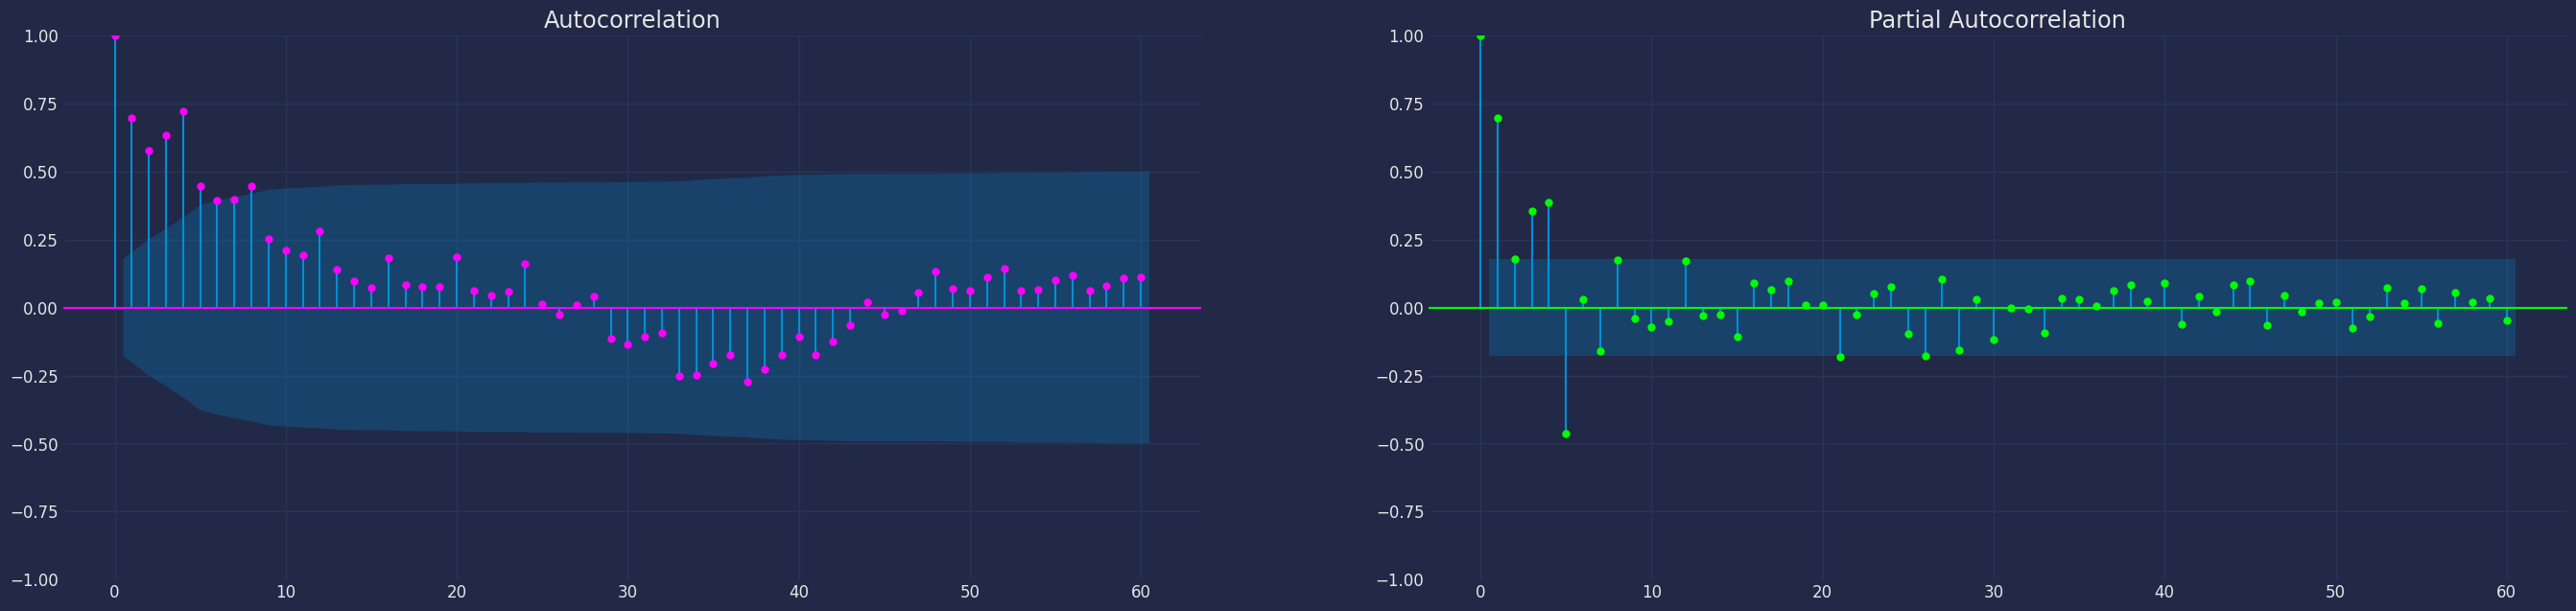

In [118]:
matplotlib.rcParams['figure.figsize'] = (30, 7)
bc = bc_tri['BALANCA_COMERCIAL'].reset_index()
bc.loc[:, 'lag1_bc'] = bc['BALANCA_COMERCIAL'].shift(1)
bc['Date'] = pd.to_datetime(bc['Date'])
bc.set_index('Date', inplace=True)

autocorr = bc['BALANCA_COMERCIAL'].autocorr(lag=1)
print(f"Autocorrelação entre os trimestres: {(np.round(autocorr, 6) * 100)}%")


fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(bc["BALANCA_COMERCIAL"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation")

plot_pacf(bc["BALANCA_COMERCIAL"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show()

**y(t)=Level∗Trend∗seasonality∗Noise**

* This formula represents a time series decomposition model where:
* y(t) - The observed value at time t.
* Level - The baseline level of the time series.
* Trend - The long-term progression or direction of the time series.
* Seasonality - The repeating patterns or cycles in the time series.
* Noise - The random variation or error component in the time series.
* The components are multiplicative, meaning the observed value is the product of these factors.

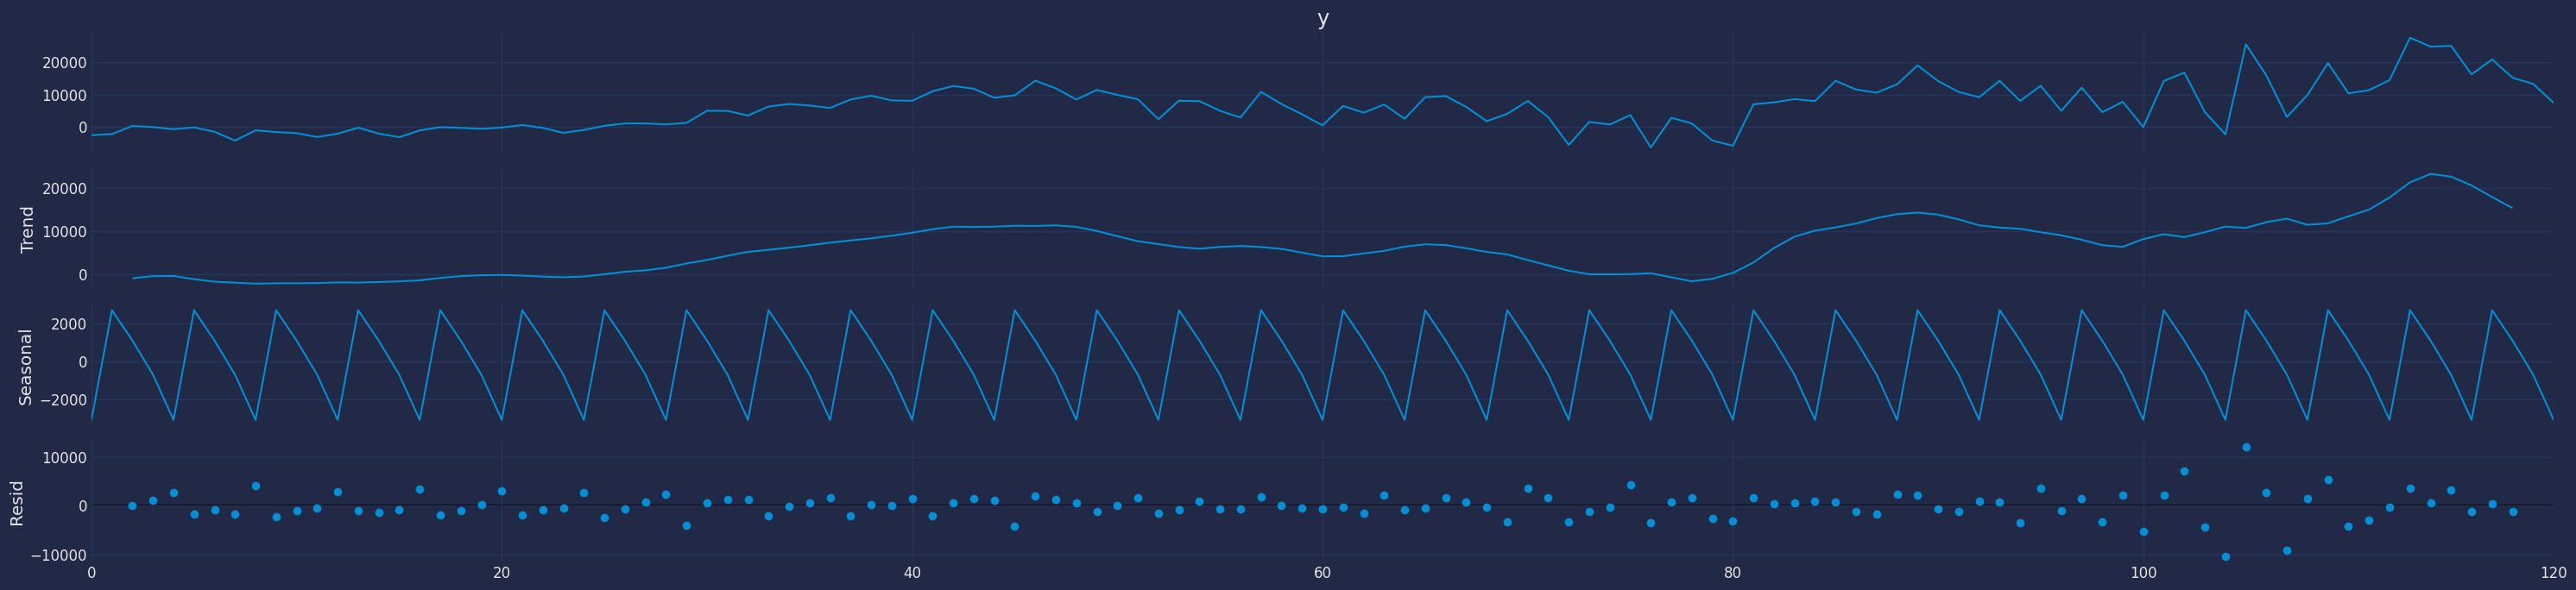

In [119]:
bc_df = (
    bc.reset_index()
    .assign(unique_id='bc')
    .rename(columns={'Date': 'ds', 'BALANCA_COMERCIAL': 'y'})
    .drop(columns=['lag1_bc'])
)

result = seasonal_decompose(bc_df['y'], model='add', period=4).plot()

models = [AutoARIMA(season_length=4, approximation=True)]
bc_df = bc_df[['unique_id', 'ds', 'y']].sort_values(by='ds')
sf = StatsForecast(
    models=models,
    freq='QE',
    n_jobs=-1
)

forecast_df = sf.forecast(df=bc_df, h=121, level=[95], fitted=True)

#adjust
insample_forecasts = sf.forecast_fitted_values().reset_index()

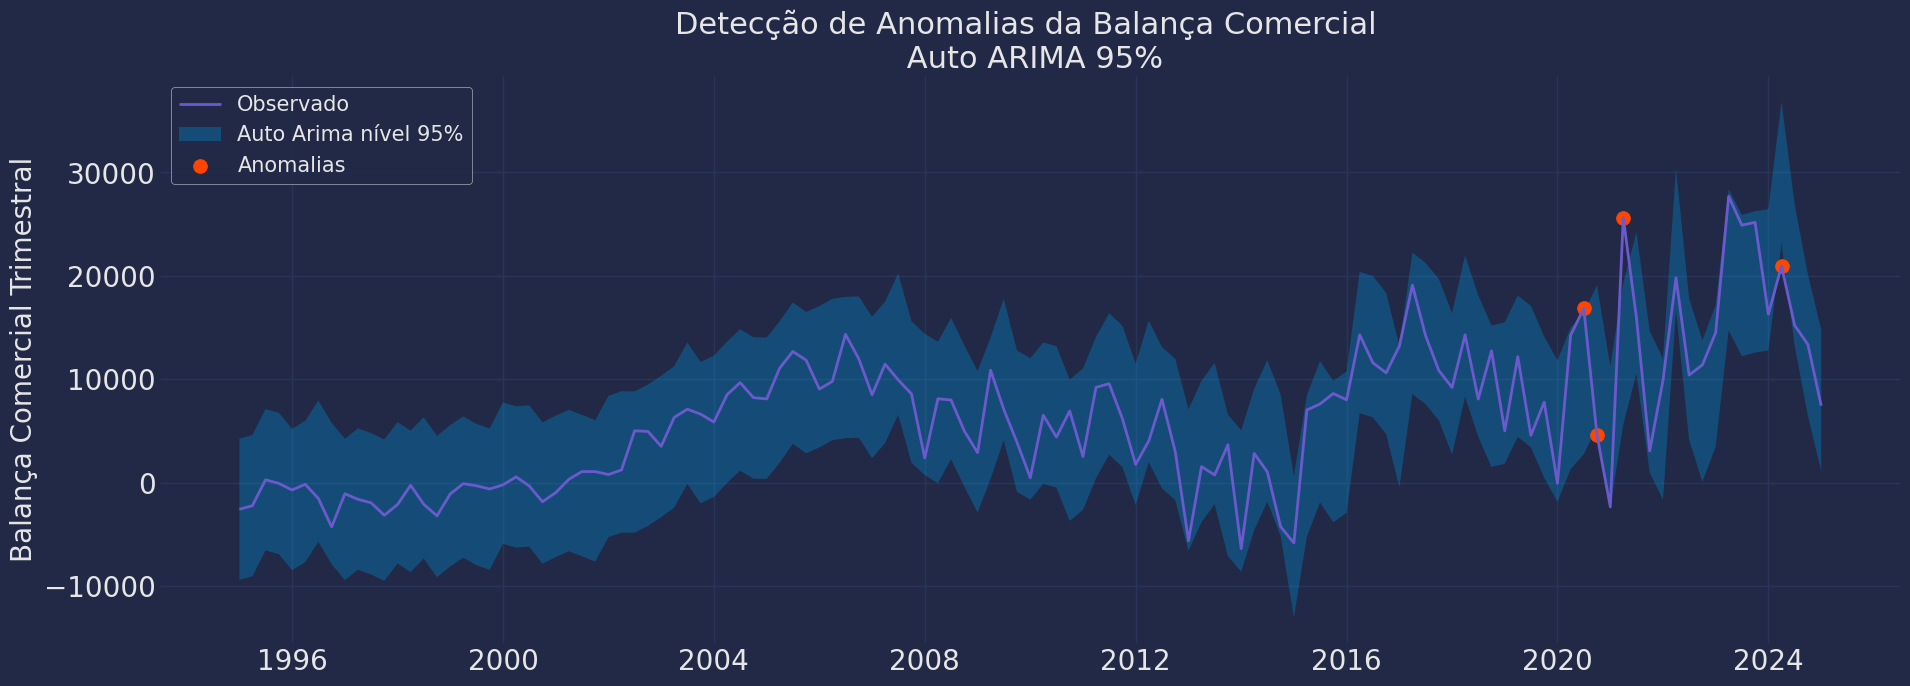

In [120]:
#plot graph
COLOR_GRAPHS_SLATEBLUE = 'slateblue'
COLOR_GRAPHS_ORANGERED = 'orangered'

fig, ax = plt.subplots(1,1, figsize=(20, 7))
ax.plot(insample_forecasts['ds'], 
        insample_forecasts['y'],
        linewidth=2, 
        label='Observado', 
        color=COLOR_GRAPHS_SLATEBLUE)

ax.fill_between(
    insample_forecasts['ds'],
    insample_forecasts['AutoARIMA-lo-95'],
    insample_forecasts['AutoARIMA-hi-95'],
    alpha = .35,
    label='Auto Arima nível 95%'
)

anomalies_df = insample_forecasts.query('y > `AutoARIMA-hi-95` or y < `AutoARIMA-lo-95`')[['ds', 'y']]
ax.scatter(
    anomalies_df['ds'], 
    anomalies_df['y'], 
    color=COLOR_GRAPHS_ORANGERED, 
    label='Anomalias',
    s=100
)

ax.set_title(f'Detecção de Anomalias da Balança Comercial \n Auto ARIMA 95%', fontsize=22)
ax.set_ylabel('Balança Comercial Trimestral', fontsize=20)
ax.legend(prop={'size': 15})
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.show()

anomalies_insights = anomalies_df.copy()

(25, 3) (96, 3)


Text(0, 0.5, 'Balança Comercial Trimestral')

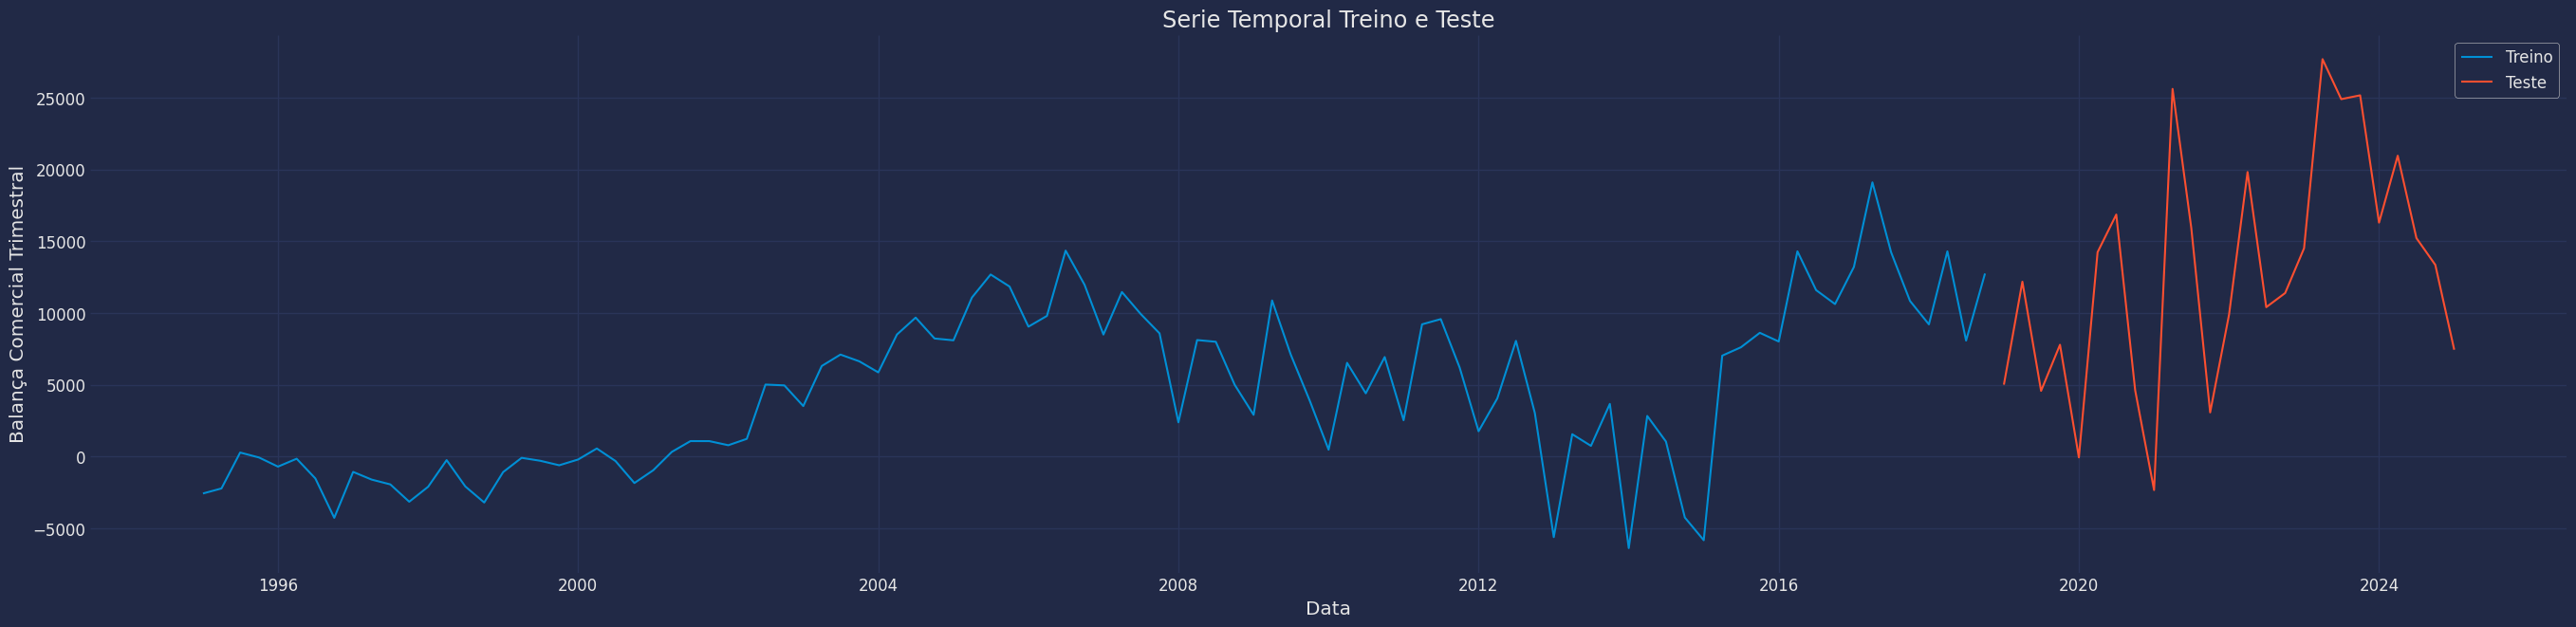

In [167]:
# training model 


split_index = int(len(bc_df) * 0.8)

Y_train_df = bc_df.iloc[:split_index]
Y_test_df = bc_df.iloc[split_index:]
print(Y_test_df.shape, Y_train_df.shape)

sns.lineplot(data=Y_train_df, x='ds', y='y', label='Treino')
sns.lineplot(data=Y_test_df, x='ds', y='y', label='Teste')
plt.title("Serie Temporal Treino e Teste")
plt.xlabel("Data")
plt.ylabel("Balança Comercial Trimestral")

In [168]:
seasson_length = 4
horizon = len(Y_test_df)

models = [AutoARIMA(season_length=seasson_length)]

sf = StatsForecast(
    models=models,
    freq='QE'
)

sf.fit(df=Y_train_df)

StatsForecast(models=[AutoARIMA])

In [169]:
StatsForecast(models=[AutoARIMA], freq='QE')

#choose better fit model to use in this time series data
arima_string(sf.fitted_[0,0].model_)

result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma']) #use cases


# look for the residual of the model

residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(1, 0, 0, 1, 4, 0, 1)


,residual Model
0,-2.569797
1,-2.218893
2,0.282406
3,-0.064697
4,1228.590397
...,...
91,-1223.062599
92,-704.715838
93,-1576.424597
94,-3148.739990


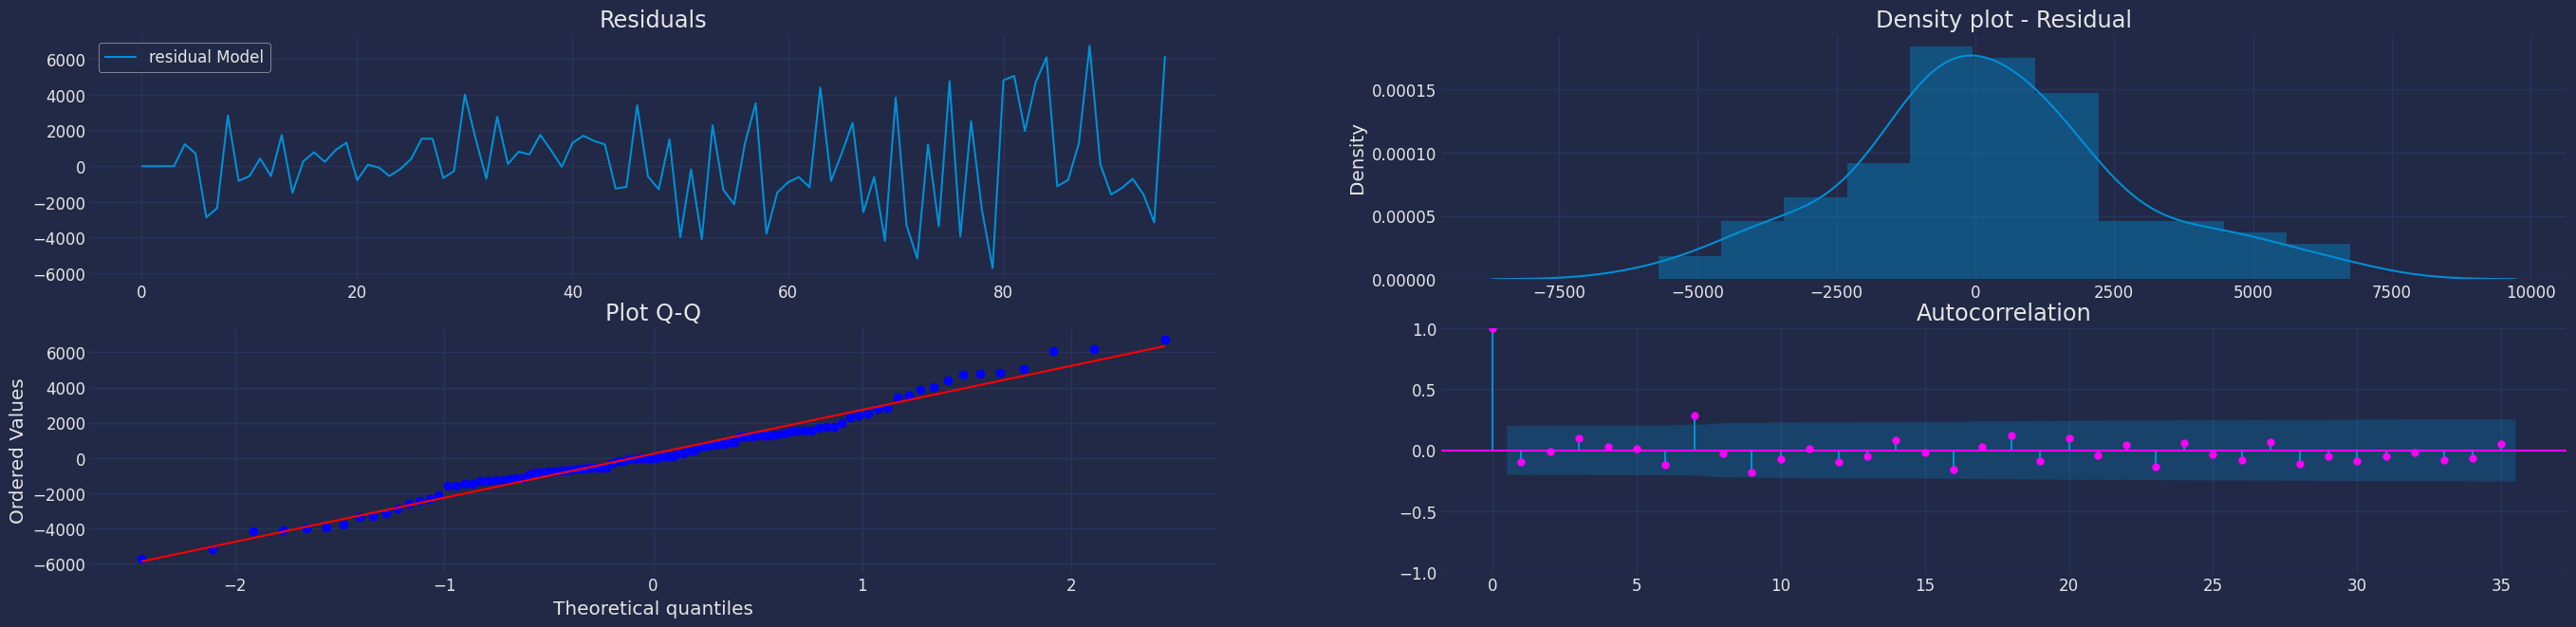

In [170]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show()

In [171]:
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon, fitted=True)
Y_hat_df

,unique_id,ds,AutoARIMA
0,bc,2018-12-31,11091.298498
1,bc,2019-03-31,16605.564808
2,bc,2019-06-30,11533.183469
3,bc,2019-09-30,12322.396365
4,bc,2019-12-31,10748.144246
5,bc,2020-03-31,16332.923342
6,bc,2020-06-30,11316.565523
7,bc,2020-09-30,12150.289989
8,bc,2020-12-31,10611.403015
9,bc,2021-03-31,16224.280276


In [172]:
values=sf.forecast_fitted_values()
values

,unique_id,ds,y,AutoARIMA
0,bc,1995-01-01,-2569.8,-2567.230203
1,bc,1995-04-01,-2218.9,-2216.681107
2,bc,1995-07-01,282.4,282.117594
3,bc,1995-10-01,-64.7,-64.635303
4,bc,1996-01-01,-699.3,-1927.890397
...,...,...,...,...
91,bc,2017-10-01,10845.4,12068.462599
92,bc,2018-01-01,9211.9,9916.615838
93,bc,2018-04-01,14300.9,15877.324597
94,bc,2018-07-01,8081.3,11230.039990


In [173]:
sf.forecast(df=Y_train_df, h=horizon, level=[95])

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,bc,2018-12-31,11091.298498,6069.828473,16112.768523
1,bc,2019-03-31,16605.564808,10192.112863,23019.016753
2,bc,2019-06-30,11533.183469,4379.150625,18687.216314
3,bc,2019-09-30,12322.396365,4738.009388,19906.783342
4,bc,2019-12-31,10748.144246,1960.886344,19535.402149
5,bc,2020-03-31,16332.923342,6864.702967,25801.143716
6,bc,2020-06-30,11316.565523,1442.634263,21190.496783
7,bc,2020-09-30,12150.289989,2028.621058,22271.958920
8,bc,2020-12-31,10611.403015,-349.006895,21571.812926
9,bc,2021-03-31,16224.280276,4765.977756,27682.582796


In [175]:
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

Y_hat_df

,unique_id,ds,y_x,y_y,AutoARIMA
0,bc,2019-01-01,5009.5,5009.5,NaN
1,bc,2019-04-01,12187.5,12187.5,NaN
2,bc,2019-07-01,4579.3,4579.3,NaN
3,bc,2019-10-01,7791.0,7791.0,NaN
4,bc,2020-01-01,-56.1,-56.1,NaN
5,bc,2020-04-01,14239.5,14239.5,NaN
6,bc,2020-07-01,16863.1,16863.1,NaN
7,bc,2020-10-01,4617.1,4617.1,NaN
8,bc,2021-01-01,-2330.6,-2330.6,NaN
9,bc,2021-04-01,25617.0,25617.0,NaN
